## 0. Preparing environment

#### Importing machine learning and data processing modules

In [1]:
import os
import pandas as pd; pd.set_option('max_colwidth', None)
import numpy as np; np.random.seed(0)
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from IPython.display import clear_output as co

from sklearn.preprocessing import binarize 
from sklearn.utils import all_estimators
classifiers = dict(all_estimators('classifier'))
import sklearn.metrics as metrics
from sklearn.metrics import classification_report as cr

C:\Users\luisr\anaconda3\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


#### Define scoring functions

In [3]:
recall_0 = metrics.make_scorer(metrics.recall_score, pos_label=0)
recall_1 = metrics.make_scorer(metrics.recall_score, pos_label=1)
precision_0 = metrics.make_scorer(metrics.precision_score, pos_label=0)
precision_1 = metrics.make_scorer(metrics.precision_score, pos_label=1)
scoring = {'accuracy': 'accuracy', 'f1_macro': 'f1_macro',
           'recall_macro': 'recall_macro', 'precision_macro': 'precision_macro',
           'recall_0': recall_0, 'recall_1': recall_1,
           'precision_0': precision_0, 'precision_1': precision_1,
          }

---
# 1. LOAD DATA

In [4]:
data = pd.read_csv('data/grades/5th_grade.csv', index_col=0)
data.drop('ID_ALUNO', 1, inplace=True)

# Loading data information dictionaries
data_path = '/Users/luisr/Desktop/Repositories/Data/saep/CSV/{}'
grades = [5,9,3]; dict_filenames = [f'dicionario {i}ano.csv' for i in grades]
dicts = {grade: pd.read_csv(data_path.format(filename)).set_index('questão') for grade, filename in zip(grades, dict_filenames)}

#### Defining targets corresponding to each student grade
targets = { # Abandonment
    5: 'TX_RESP_Q049',
    9: 'TX_RESP_Q050',
    12: 'TX_RESP_Q044',
}
grade = 5
target = targets[grade]

#### List different types of features
ids = data.columns[:10].tolist()
questions = data.columns[10:64].tolist()
grades = data.columns[64:].tolist()

---
# 2. DATA TRANSFORMATION
### Binarize target & fill missing values

In [5]:
# eliminate rows where the target variable value is missing. obs: last label represent missing values (Label 3)
modeling_data = data[data[target]!=data[target].max()].copy()
# target variable binary conversion
modeling_data[target] = binarize(modeling_data[[target]], threshold=0.5).reshape(-1)

# define X and Y
Y = modeling_data[target].reset_index(drop=True).copy()
X = modeling_data.reset_index(drop=True).drop(target, 1)

# FILLING MISSING VALUES WITH VARIABLES' MEANS
for grade in grades:
    X[grade].fillna(X[grade].mean(), inplace=True)
    
# target variable class count
print(Y.value_counts())

0    397232
1     50087
Name: TX_RESP_Q049, dtype: int64


---
# 3. FEATURE  SELECTION FOR CLASSIFICATION MODELING

#### Compare performance of different:
* Models
* Random train splits
* Target variable class ratios
* Train sizes (Learning curve)
* Model hyperparameters

## 3.1 Sampling

#### Representative imbalanced test sample

In [22]:
from splitter import UnderSampleSplit
uss = UnderSampleSplit(
    train_size=0.04, train_prct=1,
    test_size=0.2, test_prct=8,
    replace=False, shuffle=True,
)

train_index, test_index = uss.train_test_undersample(Y, random_state=0)
xt, xe, yt, ye = X.loc[train_index], X.loc[test_index], Y.loc[train_index], Y.loc[test_index]

In [23]:
print_cls_cnt(Y, train_index, test_index)

,Train set,Test set
Class,,
0,2003,80144
1,2003,10018


---
# FEATURE SELECTION

In [81]:
from sklearn.feature_selection import RFE, RFECV, SequentialFeatureSelector, f_classif

#### Importing models for comparison

In [77]:
from imblearn.ensemble import (
    BalancedRandomForestClassifier as BRFC
)
GBC = classifiers['GradientBoostingClassifier']
RFC = classifiers['RandomForestClassifier']

models = ('DecisionTreeClassifier', 'ExtraTreesClassifier', 'LogisticRegression', 'RidgeClassifier', 'RandomForestClassifier', 'LinearDiscriminantAnalysis', 'LinearSVC')
Models = [classifiers[model]() for model in models]

# Fit and score baseline model

In [79]:
model_fit = GBC(n_estimators=100, verbose=0).fit(xt, yt)
print(cr(ye, model_fit.predict(xe)))

              precision    recall  f1-score   support

           0       0.95      0.69      0.80     80144
           1       0.22      0.70      0.33     10018

    accuracy                           0.69     90162
   macro avg       0.58      0.70      0.57     90162
weighted avg       0.87      0.69      0.75     90162



# Retrieve feature importance

In [90]:
# fi = model_fit.feature_importances_
fi = f_classif(xt, yt)[0]
feature_importance = pd.Series(fi, index=X.columns).sort_values(ascending=False)

#### Plot feature importance

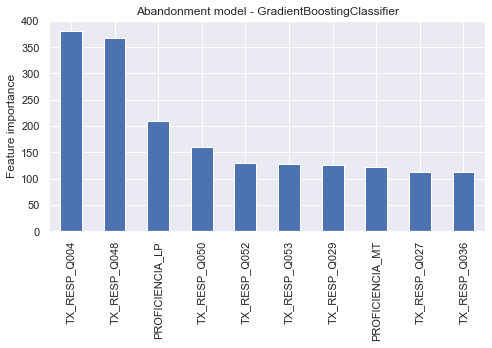

In [91]:
first, n_first = 1, 10
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
feature_importance.iloc[first-1:n_first].plot.bar(ax=ax);
plt.title(f'Abandonment model - {model_name}');
plt.ylabel('Feature importance'); plt.show()

# Fit and score baseline model based on selected features

#### Classification report for baseline model of selected features

In [99]:
n_features = 4
selected_features = feature_importance[:n_features].index.tolist()
print('Selected features:', selected_features)
xt_s = xt[selected_features]; xe_s = xe[selected_features]
yp_sel = GBC().fit(xt_s, yt).predict(xe_s)

print(cr(ye, yp_sel))

Selected features: ['TX_RESP_Q004', 'TX_RESP_Q048', 'PROFICIENCIA_LP', 'TX_RESP_Q050']
              precision    recall  f1-score   support

           0       0.95      0.65      0.77     80144
           1       0.20      0.71      0.32     10018

    accuracy                           0.66     90162
   macro avg       0.57      0.68      0.54     90162
weighted avg       0.86      0.66      0.72     90162



# Understanding selected features

In [115]:
selected = [
    'TX_RESP_Q048', 'TX_RESP_Q004',
    'TX_RESP_Q050', 'TX_RESP_Q045',
#     'TX_RESP_Q052', 'TX_RESP_Q047',
#     'TX_RESP_Q053', 'TX_RESP_Q015',
#     'TX_RESP_Q027'
]

In [116]:
pd.concat([dicts[5].loc[[col]] for col in selected]).T.dropna(how='all').replace(np.nan, '')

questão,TX_RESP_Q048,TX_RESP_Q004,TX_RESP_Q050,TX_RESP_Q045
Enunciado,Você já foi reprovado?,Qual a sua idade?,Você faz o dever de casa de língua portuguesa?,Você trabalha fora de casa?
A,Não.,8 anos ou menos.,Sempre ou quase sempre.,Sim.
B,"Sim, uma vez.",9 anos.,De vez em quando.,Não.
C,"Sim, duas vezes ou mais.",10 anos.,Nunca ou quase nunca.,
D,,11 anos.,,
E,,12 anos.,,
F,,13 anos.,,
G,,14 anos.,,
H,,15 anos ou mais,,


---
# RECURSIVE FEATURE ELIMINATION (with built-in cross validation)

In [117]:
rfeCV = RFECV(model(), step=1, min_features_to_select=1, cv=7, verbose=1).fit(xt, yt)
rfecv_selected = feature_importance.index[rfeCV.support_]

xt_s = xt[rfecv_selected]; xe_s = xe[rfecv_selected]
yp_sel = model().fit(xt_s, yt).predict(xe_s)

print(cr(ye, yp_sel))

              precision    recall  f1-score   support

           0       0.93      0.68      0.79     80144
           1       0.20      0.62      0.30     10018

    accuracy                           0.68     90162
   macro avg       0.57      0.65      0.54     90162
weighted avg       0.85      0.68      0.73     90162



In [109]:
rfeCV.n_features_

54

---
# Sequential Feature Selection¶